## Filtering

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import time

_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from functions.filtering import *
from functions.plotting import *

### Original data

In [2]:
_FOLDER = "C:/Users/junny/GitRepos/DrugProfiles_2/database/"

drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

(225384, 28)

## Filtering 1: 4 stage filtering

In [3]:
%%time
# difference between middle points 0.2
df_filt_1234 = filtering_sigmoid_curves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2, 
                         middle_points_limit = -0.2)
df_filt_1234.to_csv(_FOLDER_3+"filt_1234_02.csv", index=False)

Original dataset: (225384, 28)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 28)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 30)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 30)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2108, 30)
CPU times: total: 781 ms
Wall time: 780 ms


## Bad data after filtering 1

In [4]:
high_resp_data = find_high_responses(df_filt_1234, response_norm)

if high_resp_data.shape[0]==0:
    print("No high response data")
else: 
    print("Responses above 1:", high_resp_data.shape[0])
    df = high_resp_data
    show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

No high response data


Ascending points: 71


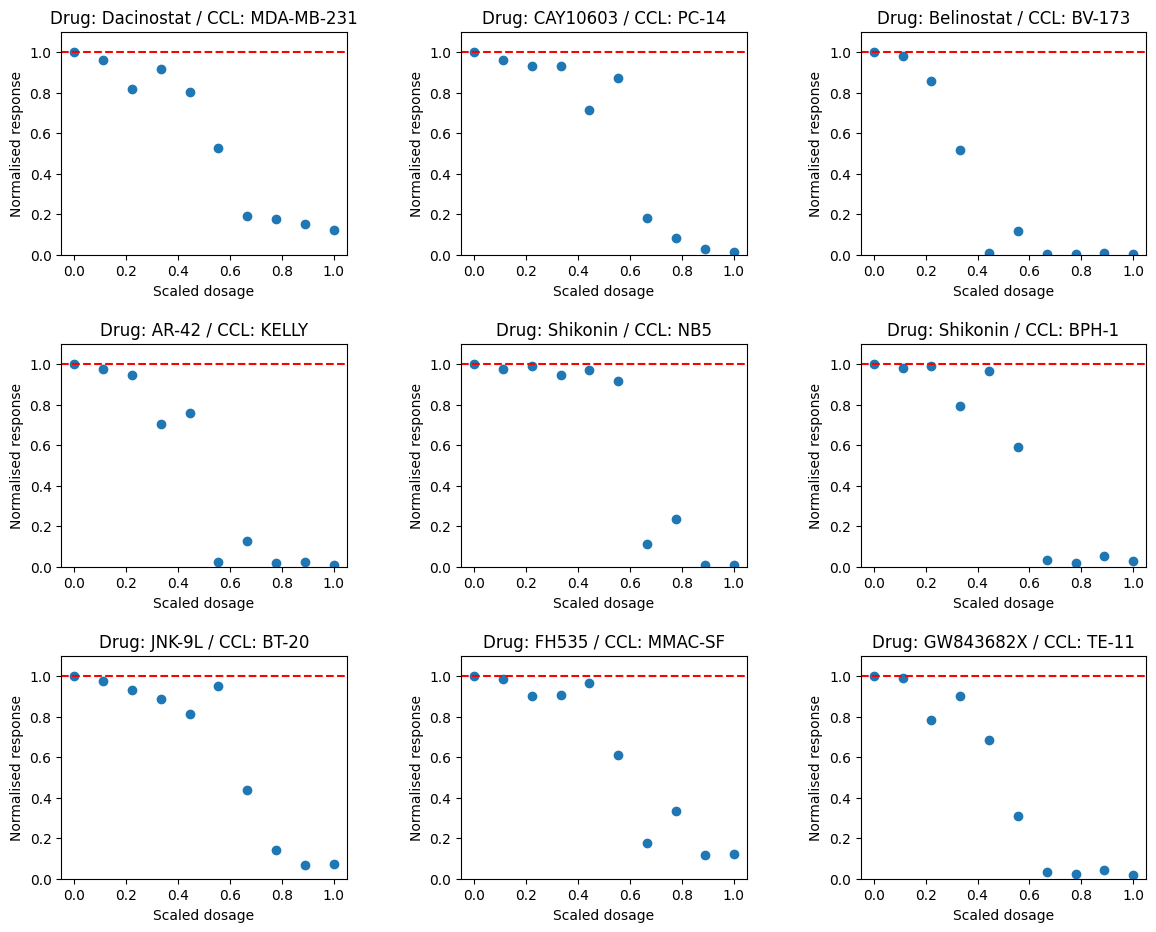

In [5]:
ascend_data = find_ascending_data(df_filt_1234, response_norm, middle_points_limit=-0.1)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 2:  auc>0.7 and spearman_r<0

In [6]:
%%time
df_filt_auc = auc_filtration(drug_curves, conc_columns, response_norm, 
                         auc_limit=0.7, final_response_limit=0.2)
df_filt_auc.to_csv(_FOLDER_3+"filt_auc_02.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████| 225384/225384 [15:27<00:00, 243.06it/s]


CPU times: total: 15min 29s
Wall time: 15min 27s


In [7]:
df_filt_auc.shape

(14084, 31)

## Bad data left after filtering 2

Responses above 1: 8404


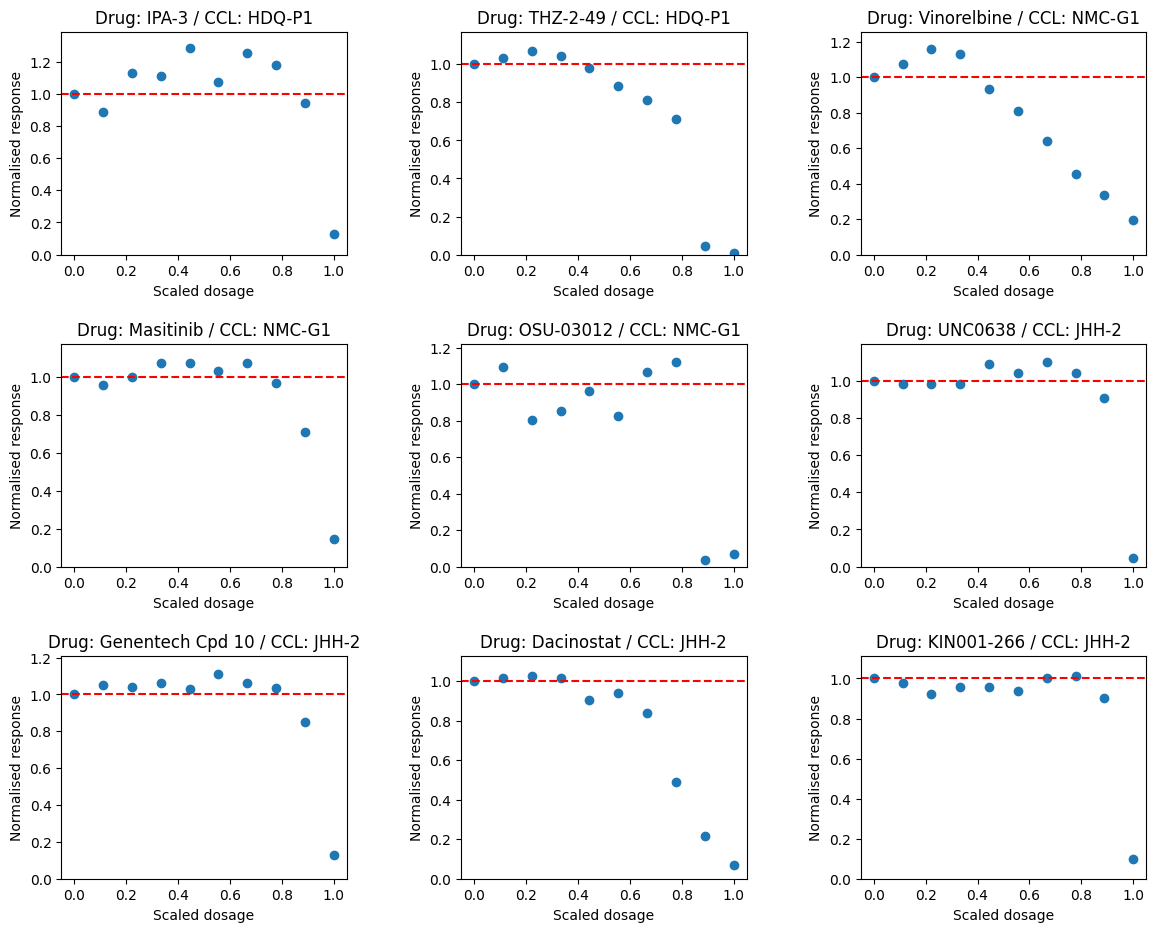

In [8]:
high_resp_data = find_high_responses(df_filt_auc, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Ascending points: 4797


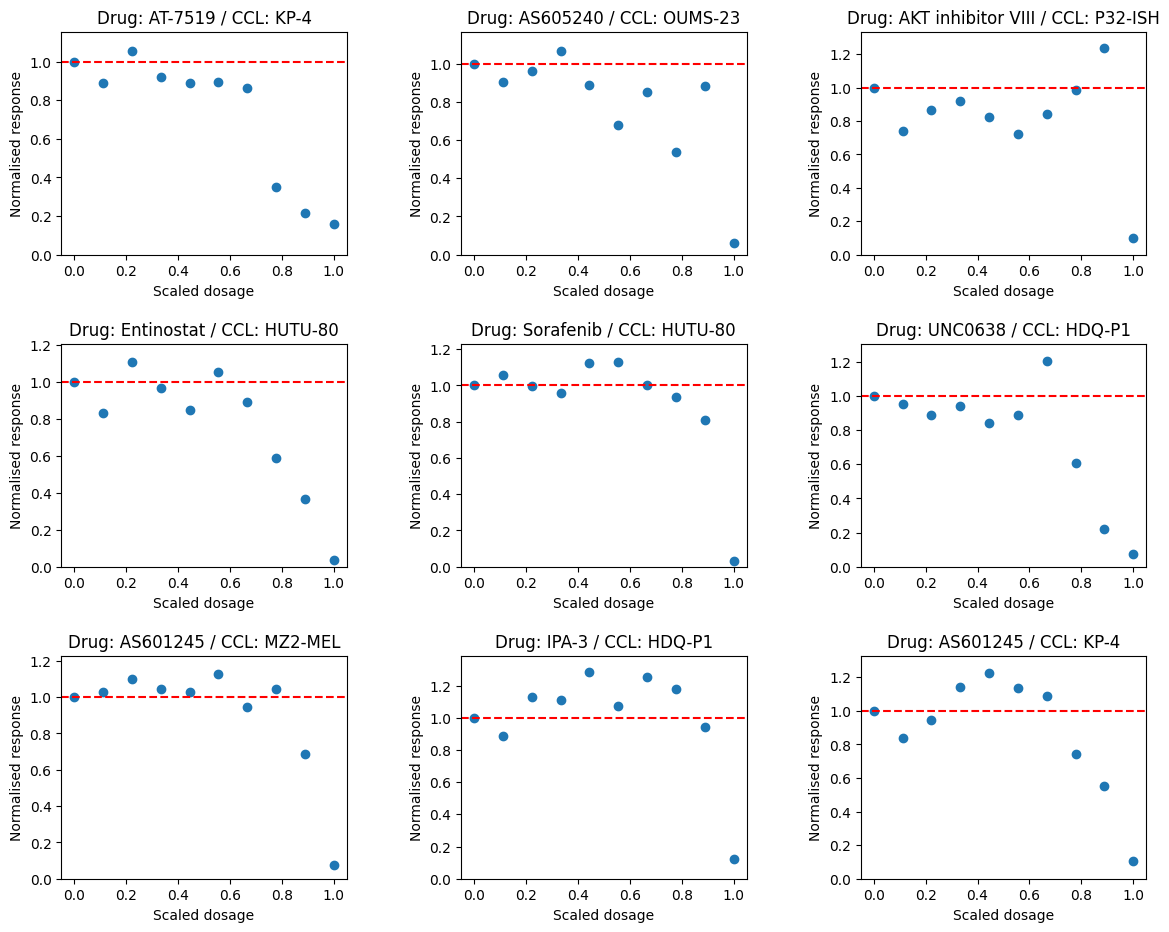

In [9]:
ascend_data = find_ascending_data(df_filt_auc, response_norm, middle_points_limit=-0.1)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 3: direct fitting

In [10]:
functions = [
             "fsigmoid", 
             "sigmoid_2_param",
             "sigmoid_3_param",
             "sigmoid_4_param",
             "logistic_4_param",
            "ll4_4_param",
            "ll4R_4_param",
            "logLogist_3_param"]

In [11]:
%%time
df_no_filt = compare_fitting_functions(drug_curves, functions, conc_columns, response_norm, 
                                       save_file_name = _FOLDER_3 +"fit_no_filt.csv")

(225384, 28)

 fsigmoid


100%|█████████████████████████████████████████████████████████████████████████| 225384/225384 [04:30<00:00, 832.34it/s]


<function fsigmoid at 0x000002305FA5CCC0>

 sigmoid_2_param


100%|████████████████████████████████████████████████████████████████████████| 225384/225384 [03:16<00:00, 1149.18it/s]


<function sigmoid_2_param at 0x000002305FA5CC20>

 sigmoid_3_param


100%|█████████████████████████████████████████████████████████████████████████| 225384/225384 [07:30<00:00, 500.28it/s]


<function sigmoid_3_param at 0x000002305FA5CD60>

 sigmoid_4_param


100%|█████████████████████████████████████████████████████████████████████████| 225384/225384 [34:06<00:00, 110.15it/s]


<function sigmoid_4_param at 0x000002305FA5CE00>

 logistic_4_param


 13%|██████████                                                                 | 30092/225384 [07:29<37:00, 87.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████| 225384/225384 [37:54<00:00, 99.09it/s]


<function ll4R_4_param at 0x000002305FA5CF40>

 logLogist_3_param


100%|█████████████████████████████████████████████████████████████████████████| 225384/225384 [32:20<00:00, 116.14it/s]


<function logLogist_3_param at 0x000002305FA5D080>




,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9,r2>0.99
fsigmoid,33900.0,-8.680730,0.999988,154649.0,78118.0,53091.0,53091.0
sigmoid_2_param,197.0,-8.680730,0.999988,151367.0,78100.0,53063.0,53063.0
sigmoid_3_param,19932.0,-0.000003,0.999998,189138.0,95607.0,70557.0,70557.0
sigmoid_4_param,27310.0,-0.000007,0.999981,119614.0,65659.0,53846.0,53846.0
logistic_4_param,27747.0,-0.607641,0.999997,163685.0,94899.0,73125.0,73125.0
ll4_4_param,27365.0,-2.963147,1.000000,163747.0,94635.0,73134.0,73134.0
ll4R_4_param,39514.0,-0.831922,0.999998,159464.0,88618.0,67848.0,67848.0
logLogist_3_param,49419.0,-177.845334,1.000000,144487.0,91132.0,72883.0,72883.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 146021


,COSMIC_ID,DRUG_ID,fsigmoid_r2,sigmoid_2_param_r2,sigmoid_3_param_r2,sigmoid_4_param_r2,logistic_4_param_r2,ll4_4_param_r2,ll4R_4_param_r2,logLogist_3_param_r2,better_fitting
0,1290922,332,-0.356726,-0.356726,0.037388,0.000000e+00,0.200629,0.000000,0.041894,0.000000,logistic_4_param
4,1290922,192,-0.362288,-0.362288,0.216033,0.000000e+00,0.501660,0.501660,0.501660,0.496308,logistic_4_param
6,1290922,310,0.752543,0.752543,0.922580,3.190755e-09,0.936430,0.936430,0.936430,0.559952,ll4_4_param
7,1290922,306,0.717145,0.717145,0.774391,2.542749e-09,0.774391,0.774391,0.774392,-1.772116,ll4R_4_param
8,1290922,225,0.769099,0.769099,0.806332,0.000000e+00,0.804881,0.804868,0.804881,-0.144585,sigmoid_3_param


CPU times: total: 2h 55min 8s
Wall time: 2h 59min 50s
